In [1]:
import numpy as np
import pandas as pd
import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.datasets import load_digits
from IPython.display import display, HTML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import math, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, Reshape, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, ZeroPadding2D
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


C:\Users\fuers\Anaconda3\envs\CS6476\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
hyperparameters = {
    'tree': {

        'max_depth': [2, 4, 8, 16, 32, 64, 128, None],
        'min_samples_split':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
        'min_samples_leaf':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],


    },
    'SVM': {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'KNN': {
        'n_neighbors': np.arange(1, 10, 1)
    },
    'adaboost': {
        'n_estimators': np.arange(1, 150, 10),

    }

}

In [3]:
def load_data():
    df_train = pd.read_csv("data/mnist/csv_format/train.csv")
    df_test = pd.read_csv("data/mnist/csv_format/test.csv")
    X = []
    y = []
    for row in df_train.iterrows() :
        label = row[1][0]
        image = list(row[1][1:])
        image = np.array(image) / 255 #normalize vals
        X.append(image)
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    sns.countplot(df_train['label'])
    plt.savefig("./output/label_count_mnist.png")
    return(X, y)

def split_data(X, y, data_size=1.0, train_size=0.8, strat=False):
    if strat:
        sss = StratifiedShuffleSplit(n_splits=1, random_state=0, train_size=train_size, test_size=train_size/4)
        for train_index, test_index in sss.split(X, y):
            print("hm")
            X_train = X[train_index]
            X_test = X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=train_size/4)
    return(X_train, y_train, X_test, y_test)


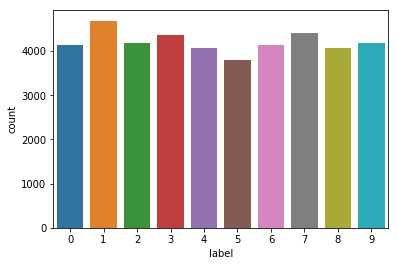

In [4]:
X, y = load_data()



In [5]:
X_train, X_holdout_test, y_train, y_holdout_test = train_test_split(X, y, test_size=0.016)
X_train, y_train, X_test, y_test = split_data(X_train, y_train, train_size=0.08)
print(X_train.shape)
print(X_test.shape)
print(X_holdout_test.shape)

(3306, 784)
(827, 784)
(672, 784)


In [6]:

def test_hyperparams(classifier, range, args, arg_to_iterate):
    train_accs = []
    test_accs = []
    a = args

    for i in range:
        a[arg_to_iterate] = i
        clf = classifier(**a)
        clf = clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score =clf.score(X_test, y_test)
        #print("i=%d, accuracy=%.2f%%" % (i, test_score * 100))
        train_accs.append(train_score* 100)
        test_accs.append(test_score* 100)
        best_metric = range[np.argmax(test_accs)]
    return test_accs, train_accs, best_metric

def plot_hyperparam_test(test_accs, train_accs, n_range, dataset, model_name, param_name, hist=False):

    plt.plot(n_range, train_accs, label = "train acc")
    plt.plot(n_range, test_accs, label = "test acc")
    plt.legend()

    plt.xlabel(param_name)
    plt.ylabel("test accuracy")
    title = "" + model_name + " score for " + param_name
    plt.title(title)
    plt.show()
    plt.savefig("./output/" + dataset + "-" + model_name + "-" + param_name + ".png")

def run_gridsearchCV(classifier, params, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(classifier, param_grid=params, cv=5, verbose=10, n_jobs=-1)
    grid.fit(X_train, y_train)
    train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_test, y_test)
    return(train_score, test_score, grid.best_params_)

def tune_knn(X_train, y_train, X_test, y_test):
    kVals = np.arange(1, 30, 1)
    gscv_train, gscv_test, best_params = run_gridsearchCV(
        KNeighborsClassifier(),
        {
            'n_neighbors': kVals
        },
        X_train, y_train, X_test, y_test
    )
    print(gscv_train)
    print(gscv_test)
    print(best_params)
    
def tune_decision_tree(X_train, y_train, X_test, y_test):
    kVals = np.arange(1, 30, 1)
    gscv_train, gscv_test, best_params = run_gridsearchCV(
        tree.DecisionTreeClassifier(),
        {
           'max_depth': [2, 4, 8, 16, 32, 64, 128, None],
            'min_samples_split':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
            'min_samples_leaf':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
        },
        X_train, y_train, X_test, y_test
    )
    print(gscv_train)
    print(gscv_test)
    print(best_params)
    
def tune_SVM(X_train, y_train, X_test, y_test):
    kVals = np.arange(1, 30, 1)
    gscv_train, gscv_test, best_params = run_gridsearchCV(
        SVC(),
        {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf', 'linear', 'poly']
        },
        X_train, y_train, X_test, y_test
    )
    print(gscv_train)
    print(gscv_test)
    print(best_params)
    
def tune_adaboost(X_train, y_train, X_test, y_test):
    kVals = np.arange(1, 30, 1)
    
    params = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "base_estimator__max_depth" :   np.arange(2, 12, 1),
                  "n_estimators": np.arange(1, 150, 10)
                 }


  
    clf = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto"))
    
    gscv_train, gscv_test, best_params = run_gridsearchCV(
        clf,
        params,
        X_train, y_train, X_test, y_test
    )
    print(gscv_train)
    print(gscv_test)
    print(best_params)





# KNN

In [10]:
tune_knn(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 137 out of 145 | elapsed:  1.9min remaining:    6.7s
[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:  2.0min finished


1.0
0.9166666666666666
{'n_neighbors': 1}


In [7]:
params = {
    'n_neighbors': 1
}
n_range = np.arange(1, 10, 1)

test_accs, train_accs, best_metric = test_hyperparams(KNeighborsClassifier, 
                                                      n_range, 
                                                      params,
                                                      'n_neighbors' 
                                                     )
print(test_accs)
print(train_accs)
print(best_metric)

i=1, accuracy=93.21%
i=2, accuracy=90.83%
i=3, accuracy=91.07%
i=4, accuracy=92.02%
i=5, accuracy=92.26%
i=6, accuracy=91.90%
i=7, accuracy=91.31%
i=8, accuracy=90.71%
i=9, accuracy=90.95%
i=10, accuracy=90.83%
i=11, accuracy=90.48%
i=12, accuracy=90.48%
i=13, accuracy=90.48%
i=14, accuracy=90.12%
i=15, accuracy=89.76%
i=16, accuracy=89.88%
i=17, accuracy=90.00%
i=18, accuracy=90.00%
i=19, accuracy=89.64%
i=20, accuracy=90.24%
i=21, accuracy=90.36%
i=22, accuracy=89.88%
i=23, accuracy=89.40%
i=24, accuracy=89.40%
i=25, accuracy=89.29%
i=26, accuracy=89.17%
i=27, accuracy=88.81%
i=28, accuracy=88.93%
i=29, accuracy=88.33%
[93.21428571428572, 90.83333333333333, 91.07142857142857, 92.02380952380952, 92.26190476190477, 91.9047619047619, 91.30952380952381, 90.71428571428571, 90.95238095238095, 90.83333333333333, 90.47619047619048, 90.47619047619048, 90.47619047619048, 90.11904761904762, 89.76190476190476, 89.88095238095238, 90.0, 90.0, 89.64285714285715, 90.23809523809524, 90.35714285714286

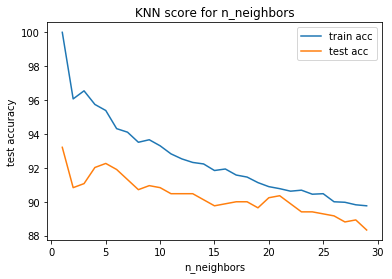

<Figure size 432x288 with 0 Axes>

In [15]:
n_range = np.arange(1, 30, 1)
plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "KNN", "n_neighbors")

In [20]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_holdout_test)
print(metrics.accuracy_score(y_holdout_test, y_pred))

0.9434523809523809


In [21]:
knn_test_acc = 0.9434523809523809

# Decision tree

In [23]:
tune_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

0.8953418027828192
0.7557436517533253
{'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2}


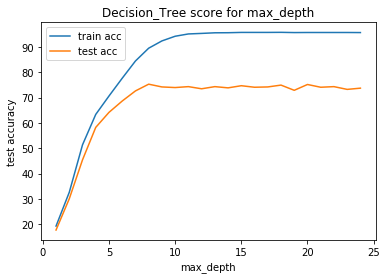

test acc:  [17.77509068923821, 30.10882708585248, 45.46553808948005, 58.28295042321644, 64.20798065296252, 68.6819830713422, 72.67230955259976, 75.33252720677146, 74.24425634824668, 74.00241837968561, 74.36517533252722, 73.51874244256348, 74.36517533252722, 73.88149939540509, 74.72793228536881, 74.12333736396614, 74.24425634824668, 74.96977025392987, 72.91414752116083, 75.21160822249094, 74.12333736396614, 74.36517533252722, 73.27690447400241, 73.76058041112455]
train acc:  [19.328493647912886, 32.66787658802178, 51.39140955837871, 63.39987900786449, 70.659407138536, 77.6769509981851, 84.48275862068965, 89.53418027828192, 92.40774349667271, 94.25287356321839, 95.16031457955233, 95.37205081669691, 95.6140350877193, 95.6442831215971, 95.76527525710829, 95.76527525710829, 95.76527525710829, 95.79552329098608, 95.70477918935269, 95.73502722323049, 95.73502722323049, 95.73502722323049, 95.73502722323049, 95.70477918935269]
8


<Figure size 432x288 with 0 Axes>

In [29]:
params ={'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2}
n_range = np.arange(1, 25, 1)

test_accs, train_accs, best_metric = test_hyperparams(tree.DecisionTreeClassifier, 
                                                      n_range, 
                                                      params,
                                                      'max_depth' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "Decision_Tree", "max_depth")
print("test acc: ", test_accs)
print("train acc: ", train_accs)
print(best_metric)

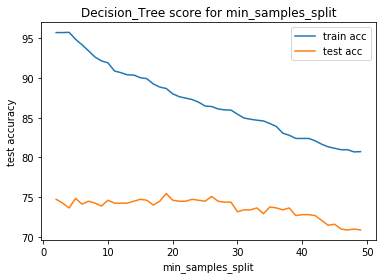

test acc:  [74.72793228536881, 74.24425634824668, 73.63966142684401, 74.84885126964933, 74.12333736396614, 74.48609431680774, 74.24425634824668, 73.88149939540509, 74.60701330108827, 74.24425634824668, 74.24425634824668, 74.24425634824668, 74.48609431680774, 74.72793228536881, 74.60701330108827, 74.00241837968561, 74.48609431680774, 75.453446191052, 74.60701330108827, 74.48609431680774, 74.48609431680774, 74.72793228536881, 74.60701330108827, 74.48609431680774, 75.0906892382104, 74.48609431680774, 74.36517533252722, 74.36517533252722, 73.15598548972189, 73.39782345828296, 73.39782345828296, 73.63966142684401, 72.91414752116083, 73.76058041112455, 73.63966142684401, 73.39782345828296, 73.63966142684401, 72.67230955259976, 72.79322853688029, 72.79322853688029, 72.67230955259976, 72.0677146311971, 71.46311970979444, 71.58403869407496, 70.97944377267231, 70.85852478839178, 70.97944377267231, 70.85852478839178]
train acc:  [95.73502722323049, 95.73502722323049, 95.76527525710829, 94.8880822

<Figure size 432x288 with 0 Axes>

In [31]:
n_range = np.arange(2, 50, 1)

test_accs, train_accs, best_metric = test_hyperparams(tree.DecisionTreeClassifier, 
                                                      n_range, 
                                                      params,
                                                      'min_samples_split' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "Decision_Tree", "min_samples_split")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)

In [32]:
params['min_samples_split'] = 19

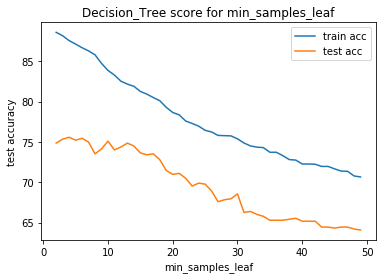

4


<Figure size 432x288 with 0 Axes>

In [33]:
n_range = np.arange(2, 50, 1)

test_accs, train_accs, best_metric = test_hyperparams(tree.DecisionTreeClassifier, 
                                                      n_range, 
                                                      params,
                                                      'min_samples_leaf' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "Decision_Tree", "min_samples_leaf")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)

In [34]:
params['min_samples_leaf'] = 4

In [35]:
clf = tree.DecisionTreeClassifier(**params)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_holdout_test)
print(metrics.accuracy_score(y_holdout_test, y_pred))
decision_tree_test_acc = metrics.accuracy_score(y_holdout_test, y_pred)

0.7752976190476191


# SVM

In [41]:
tune_SVM(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

1.0
0.9528415961305925
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


[1.  1.5 2.  2.5 3.  3.5 4.  4.5]


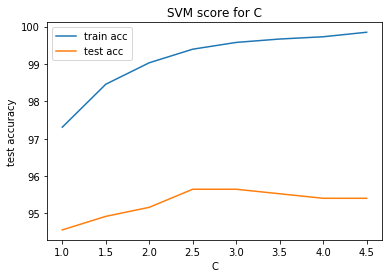

2.5


<Figure size 432x288 with 0 Axes>

In [65]:
#params = {
   # 'C': [0.1, 1, 10, 100, 1000],
  #  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 #   'kernel': ['rbf', 'linear', 'poly']
#}
params = {
    'C': 100,
    'gamma': 0.01,
    'kernel': 'rbf'
}
#0.1, 0.5,
n_range = [ 1, 2.5, 5, 7.5, 10]
n_range = np.arange(1, 5, .5)
print(n_range)
test_accs, train_accs, best_metric = test_hyperparams(SVC, 
                                                      n_range, 
                                                      params,
                                                      'C' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "SVM", "C")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['C'] = best_metric

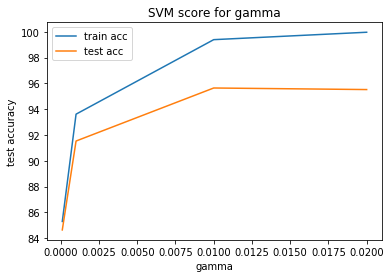

0.01


<Figure size 432x288 with 0 Axes>

In [66]:

n_range = [0.02, 0.01, 0.001, 0.0001]
test_accs, train_accs, best_metric = test_hyperparams(SVC, 
                                                      n_range, 
                                                      params,
                                                      'gamma' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "SVM", "gamma")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['gamma'] = best_metric

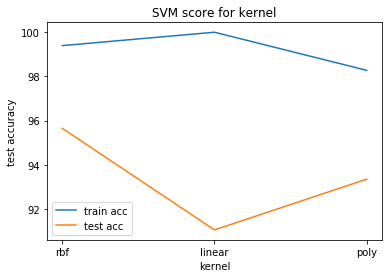

rbf


<Figure size 432x288 with 0 Axes>

In [67]:
n_range = ['rbf', 'linear', 'poly']
test_accs, train_accs, best_metric = test_hyperparams(SVC, 
                                                      n_range, 
                                                      params,
                                                      'kernel' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "SVM", "kernel")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['kernel'] = best_metric

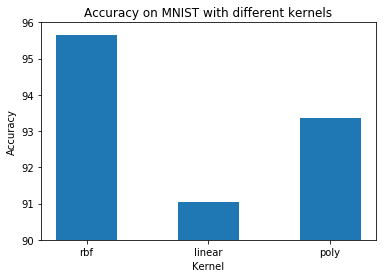

[95.64691656590084, 91.05199516324063, 93.34945586457074]


<Figure size 432x288 with 0 Axes>

In [71]:
plt.bar(n_range, test_accs, width=0.5)
plt.xlabel("Kernel")
plt.ylabel("Accuracy")
plt.title("Accuracy on MNIST with different kernels")
axes = plt.gca()
axes.set_ylim([0,100])
axes.set_ylim([90,96])
plt.show()
plt.savefig("./output/kernel_bars_mnist.png")
print(test_accs)

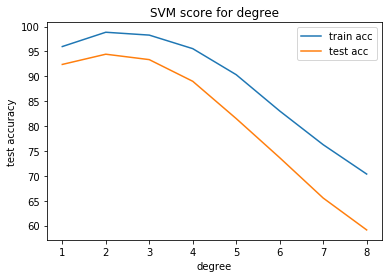

test acc:  [92.38210399032648, 94.43772672309552, 93.34945586457074, 88.99637243047158, 81.4993954050786, 73.63966142684401, 65.53808948004837, 59.12938331318017]
2


<Figure size 432x288 with 0 Axes>

In [72]:
params['kernel'] = 'poly'
params['degree'] = 1

n_range = np.arange(1, 9, 1)
test_accs, train_accs, best_metric = test_hyperparams(SVC, 
                                                      n_range, 
                                                      params,
                                                      'degree' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "SVM", "degree")
print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['degree'] = best_metric

In [73]:
params['kernel'] = 'rbf'

clf = SVC(**params)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_holdout_test)
print(metrics.accuracy_score(y_holdout_test, y_pred))
svm_test_acc = metrics.accuracy_score(y_holdout_test, y_pred)

0.9627976190476191


# ADABOOST

In [85]:
tune_adaboost(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1356s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too slow (7.9657s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.0min
[Parallel(n_j

1.0
0.932285368802902
{'base_estimator__max_depth': 10, 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'n_estimators': 111}


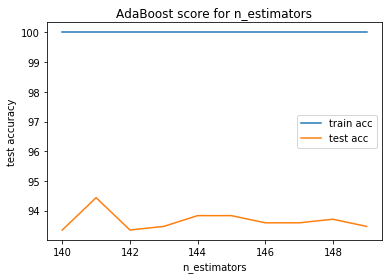

141


<Figure size 432x288 with 0 Axes>

In [91]:
base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_depth=10)
params = {'n_estimators': 111, 'base_estimator':base_estimator}

n_range = np.arange(140, 150, 1)
test_accs, train_accs, best_metric = test_hyperparams(AdaBoostClassifier, 
                                                      n_range, 
                                                      params,
                                                      'n_estimators' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "AdaBoost", "n_estimators")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['n_estimators'] = best_metric

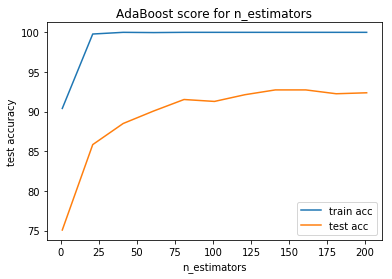

141


<Figure size 432x288 with 0 Axes>

In [101]:
base_estimator = tree.DecisionTreeClassifier(max_depth=8)
params = {'n_estimators': 111, 'base_estimator':base_estimator}

n_range = np.arange(1, 210, 20)
test_accs, train_accs, best_metric = test_hyperparams(AdaBoostClassifier, 
                                                      n_range, 
                                                      params,
                                                      'n_estimators' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "AdaBoost", "n_estimators")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['n_estimators'] = best_metric

In [89]:
print("test acc: ", test_accs)

test acc:  [75.453446191052, 85.36880290205562, 88.27085852478838, 89.35912938331319, 90.81015719467956, 91.41475211608223, 91.53567110036276, 92.86577992744861, 93.47037484885126, 93.10761789600967, 93.5912938331318, 92.62394195888754, 93.5912938331318, 93.10761789600967, 94.19588875453447]


In [99]:
params = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "base_estimator__max_depth" :   np.arange(2, 12, 1),
                  "n_estimators": np.arange(1, 150, 10)
                 }


  
clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=8), n_estimators=250)
clf.fit(X_train, y_train)                                                                     
y_pred = clf.predict(X_holdout_test)
print(metrics.accuracy_score(y_holdout_test, y_pred))
adaboost_test_acc = metrics.accuracy_score(y_holdout_test, y_pred)

0.9389880952380952


# CNN

In [7]:
from keras.applications.vgg16 import VGG16, preprocess_input


Using TensorFlow backend.


In [84]:
num_category = 10 

y_train_oh = keras.utils.to_categorical(y_train, num_category)
y_test_oh = keras.utils.to_categorical(y_test, num_category)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_33 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_51 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


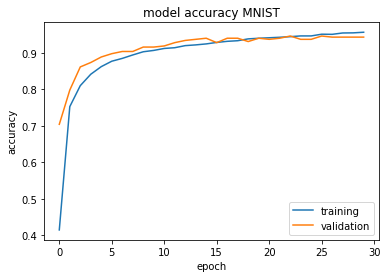

Test loss:  0.34552319681197585
Test accuracy:  0.9081015714422823


In [97]:
model = keras.models.Sequential()
model.add(Dense(units=32, activation='sigmoid', input_shape=(784,)))
model.add(Dense(units=10, activation='softmax'))

opt = keras.optimizers.Adam(lr=0.001)
loss_fn = keras.losses.categorical_crossentropy

model.compile(loss=loss_fn,
                  optimizer=opt,
                  metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_oh, batch_size=64, epochs=30, verbose=False, validation_split=.1)
loss, accuracy  = model.evaluate(X_test, y_test_oh, verbose=False)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy MNIST')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print('Test loss: ', loss)
print('Test accuracy: ', accuracy)


Train on 2975 samples, validate on 331 samples
Epoch 1/20
2975/2975 [==============================] - 2s 580us/step - loss: 1.4730 - acc: 0.5089 - val_loss: 0.5788 - val_acc: 0.8218
Epoch 2/20
2975/2975 [==============================] - 0s 136us/step - loss: 0.6625 - acc: 0.7805 - val_loss: 0.3157 - val_acc: 0.9275
Epoch 3/20
2975/2975 [==============================] - 0s 137us/step - loss: 0.4313 - acc: 0.8608 - val_loss: 0.2103 - val_acc: 0.9486
Epoch 4/20
2975/2975 [==============================] - 0s 139us/step - loss: 0.3376 - acc: 0.8881 - val_loss: 0.1531 - val_acc: 0.9607
Epoch 5/20
2975/2975 [==============================] - 0s 137us/step - loss: 0.2508 - acc: 0.9207 - val_loss: 0.1506 - val_acc: 0.9698
Epoch 6/20
2975/2975 [==============================] - 0s 136us/step - loss: 0.2118 - acc: 0.9341 - val_loss: 0.1204 - val_acc: 0.9758
Epoch 7/20
2975/2975 [==============================] - 0s 136us/step - loss: 0.2194 - acc: 0.9314 - val_loss: 0.1049 - val_acc: 0.9728
E

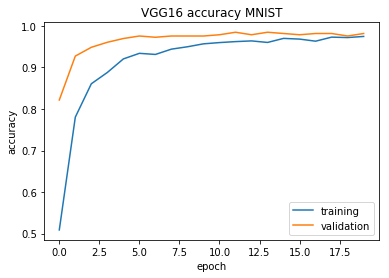

Test loss:  0.1276514095151763
Test accuracy:  0.9625151148730351


In [101]:
num_category = 10 

y_train_oh = keras.utils.to_categorical(y_train, num_category)
y_test_oh = keras.utils.to_categorical(y_test, num_category)

model = keras.Sequential()

model.add(Reshape((28, 28, 1), input_shape=(X_train.shape[1],)))
model.add(Conv2D(4, (2, 2), activation='relu', ))
model.add(Conv2D(8, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (2, 2), activation='relu'))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Train and fit the model:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = model.fit(X_train, y_train_oh, epochs=20, verbose=1, batch_size=32,  validation_split=.1)
loss, accuracy  = model.evaluate(X_test, y_test_oh, verbose=False)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG16 accuracy MNIST')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print('Test loss: ', loss)
print('Test accuracy: ', accuracy)


(784,)